In [1]:
# !pip install torch transformers accelerate pillow matplotlib numpy scipy pymupdf opencv-python -q

In [2]:
import os
import sys

# Отключаем лишние предупреждения
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OPENCV_LOG_LEVEL"] = "ERROR"

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import random

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")


Using MPS (Apple Silicon)
Device: mps


 - ТАМ директорию я положил внутрь текущей директории (hw5/TAM)
 - В качестве модели возьмем Qwen/Qwen2-VL-2B-Instruct, чтобы она влезла на мой локальный ноут

In [3]:
import sys, os
tam_dir = os.path.abspath('TAM')
if tam_dir not in sys.path:
    sys.path.insert(0, tam_dir)

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_utils import process_vision_info
from tam import TAM, rank_guassian_filter

model_name = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if device.type != "cpu" else torch.float32,
    device_map="auto" if device.type == "cuda" else None
)

if device.type == "mps":
    model = model.to(device)

processor = AutoProcessor.from_pretrained(model_name)


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


## Возьмем картинку для теста из репо ТАМ

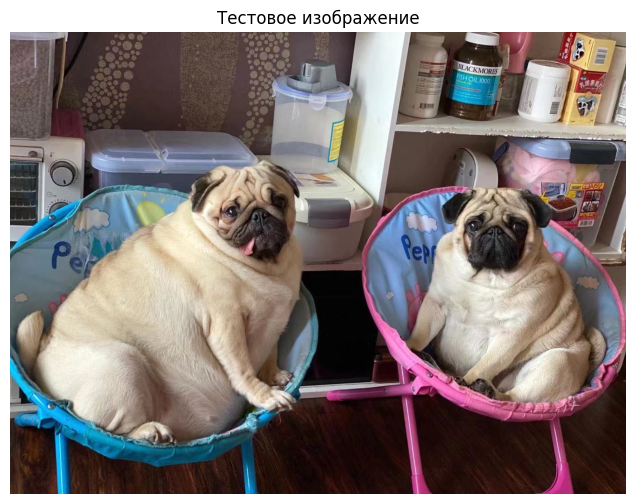

In [4]:
demo_image_path = "TAM/imgs/demo.jpg"

demo_image = Image.open(demo_image_path)
plt.figure(figsize=(8, 6))
plt.imshow(demo_image)
plt.title("Тестовое изображение")
plt.axis('off')
plt.show()


## Функция для применения TAM

In [5]:
def run_tam_analysis(image_path, prompt, model, processor, save_dir='vis_results', max_tokens=50, max_maps=10):
    os.makedirs(save_dir, exist_ok=True)
    
    messages = [{"role": "user", "content": [
        {"type": "image", "image": image_path},
        {"type": "text", "text": prompt}
    ]}]
    
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt")
    inputs = inputs.to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            use_cache=True,
            output_hidden_states=True,
            return_dict_in_generate=True
        )
    
    generated_ids = outputs.sequences
    generated_text = processor.batch_decode(generated_ids[:, inputs['input_ids'].shape[1]:], skip_special_tokens=True)[0]
    
    logits = [model.lm_head(feats[-1]) for feats in outputs.hidden_states]    
    # Специальные токены Qwen2-VL
    special_ids = {
        'img_id': [151652, 151653],
        'prompt_id': [151653, [151645, 198, 151644, 77091]],
        'answer_id': [[198, 151644, 77091, 198], -1]
    }
    
    vision_shape = (inputs['image_grid_thw'][0, 1] // 2, inputs['image_grid_thw'][0, 2] // 2)
    vis_inputs = image_inputs
    
    raw_map_records = []
    img_maps = []
    n_tokens = min(max_maps, len(logits)) 
    
    for i in range(n_tokens):
        try:
            img_map = TAM(
                generated_ids[0].cpu().tolist(), vision_shape, logits, special_ids,
                vis_inputs, processor, os.path.join(save_dir, f'token_{i}.jpg'),
                i, raw_map_records, True
            )
            img_maps.append(img_map)
        except Exception as e:
            print(f"Ошибка токена {i}: {e}")
            break
    
    return {'text': generated_text, 'maps': img_maps, 'shape': vision_shape, 'n_tokens': len(logits)}


## Тестирование TAM на 1 изображении и соответствующем промпте

In [6]:
test_prompts = [
    "Describe this image.",
    "Is the dog in the image?",
    "What objects can you see?",
    "What is the main subject?"
]

prompt = test_prompts[1]

results = run_tam_analysis(demo_image_path, prompt, model, processor)
print(f"\nОтвет модели: {results['text']}")
print(f"Форма визуальных токенов: {results['shape']}")
print(f"Токенов сгенерировано: {results['n_tokens']}")
print(f"Карт активации: {len(results['maps'])}")

Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.

Ответ модели: Yes, the dog in the image is a pug.
Форма визуальных токенов: (tensor(39, device='mps:0'), tensor(51, device='mps:0'))
Токенов сгенерировано: 13
Карт активации: 10


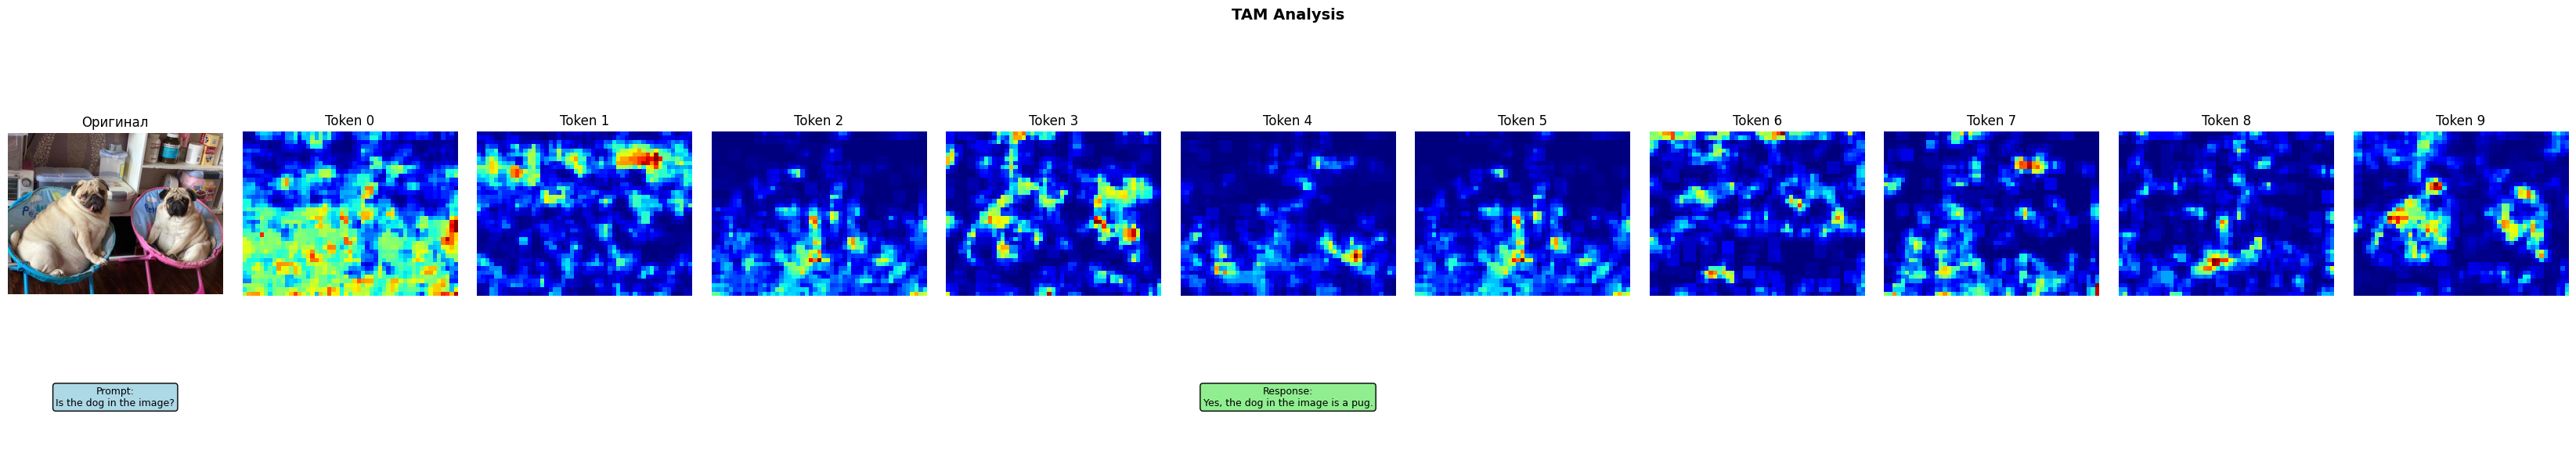

In [7]:
if results and len(results['maps']) > 0:
    n_maps = min(10, len(results['maps']))
    fig, axes = plt.subplots(2, n_maps + 1, figsize=(3 * (n_maps + 1), 6), 
                             gridspec_kw={'height_ratios': [3, 1]})
    
    axes[0, 0].imshow(Image.open(demo_image_path))
    axes[0, 0].set_title('Оригинал')
    axes[0, 0].axis('off')
    
    for i in range(n_maps):
        img_map = results['maps'][i]
        if isinstance(img_map, np.ndarray):
            axes[0, i + 1].imshow(img_map, cmap='jet')
            axes[0, i + 1].set_title(f'Token {i}')
        axes[0, i + 1].axis('off')
    
    for ax in axes[1]:
        ax.axis('off')
    
    axes[1, 0].text(0.5, 0.5, f"Prompt:\n{prompt}", ha='center', va='center', 
                    fontsize=9, wrap=True, bbox=dict(boxstyle='round', facecolor='lightblue'))
    
    response_text = results['text'][:100] + ('...' if len(results['text']) > 100 else '')
    mid_col = (n_maps + 1) // 2
    axes[1, mid_col].text(0.5, 0.5, f"Response:\n{response_text}", ha='center', va='center',
                          fontsize=9, wrap=True, bbox=dict(boxstyle='round', facecolor='lightgreen'))
    
    plt.suptitle(f"TAM Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Теперь посмотрим на разных промптах

In [8]:
all_results = {}

for i, prompt in enumerate(test_prompts):
    result = run_tam_analysis(demo_image_path, prompt, model, processor, save_dir=f'vis_results/p{i}')
    all_results[prompt] = result
    print(f"Ответ: {result['text'][:150]}...")
    print(f"Карт: {len(result['maps'])}")

Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, please check the installation of texlive-xetex.
Ответ: The image shows two pugs sitting in colorful, round chairs. The chairs are designed with a playful and whimsical design, featuring a blue and pink col...
Карт: 10
Skip text visualization, please check the installation of texlive-xetex.
Skip text visualization, pl

## Посмотрим на бОльшем примере промтов на работу ТАМ

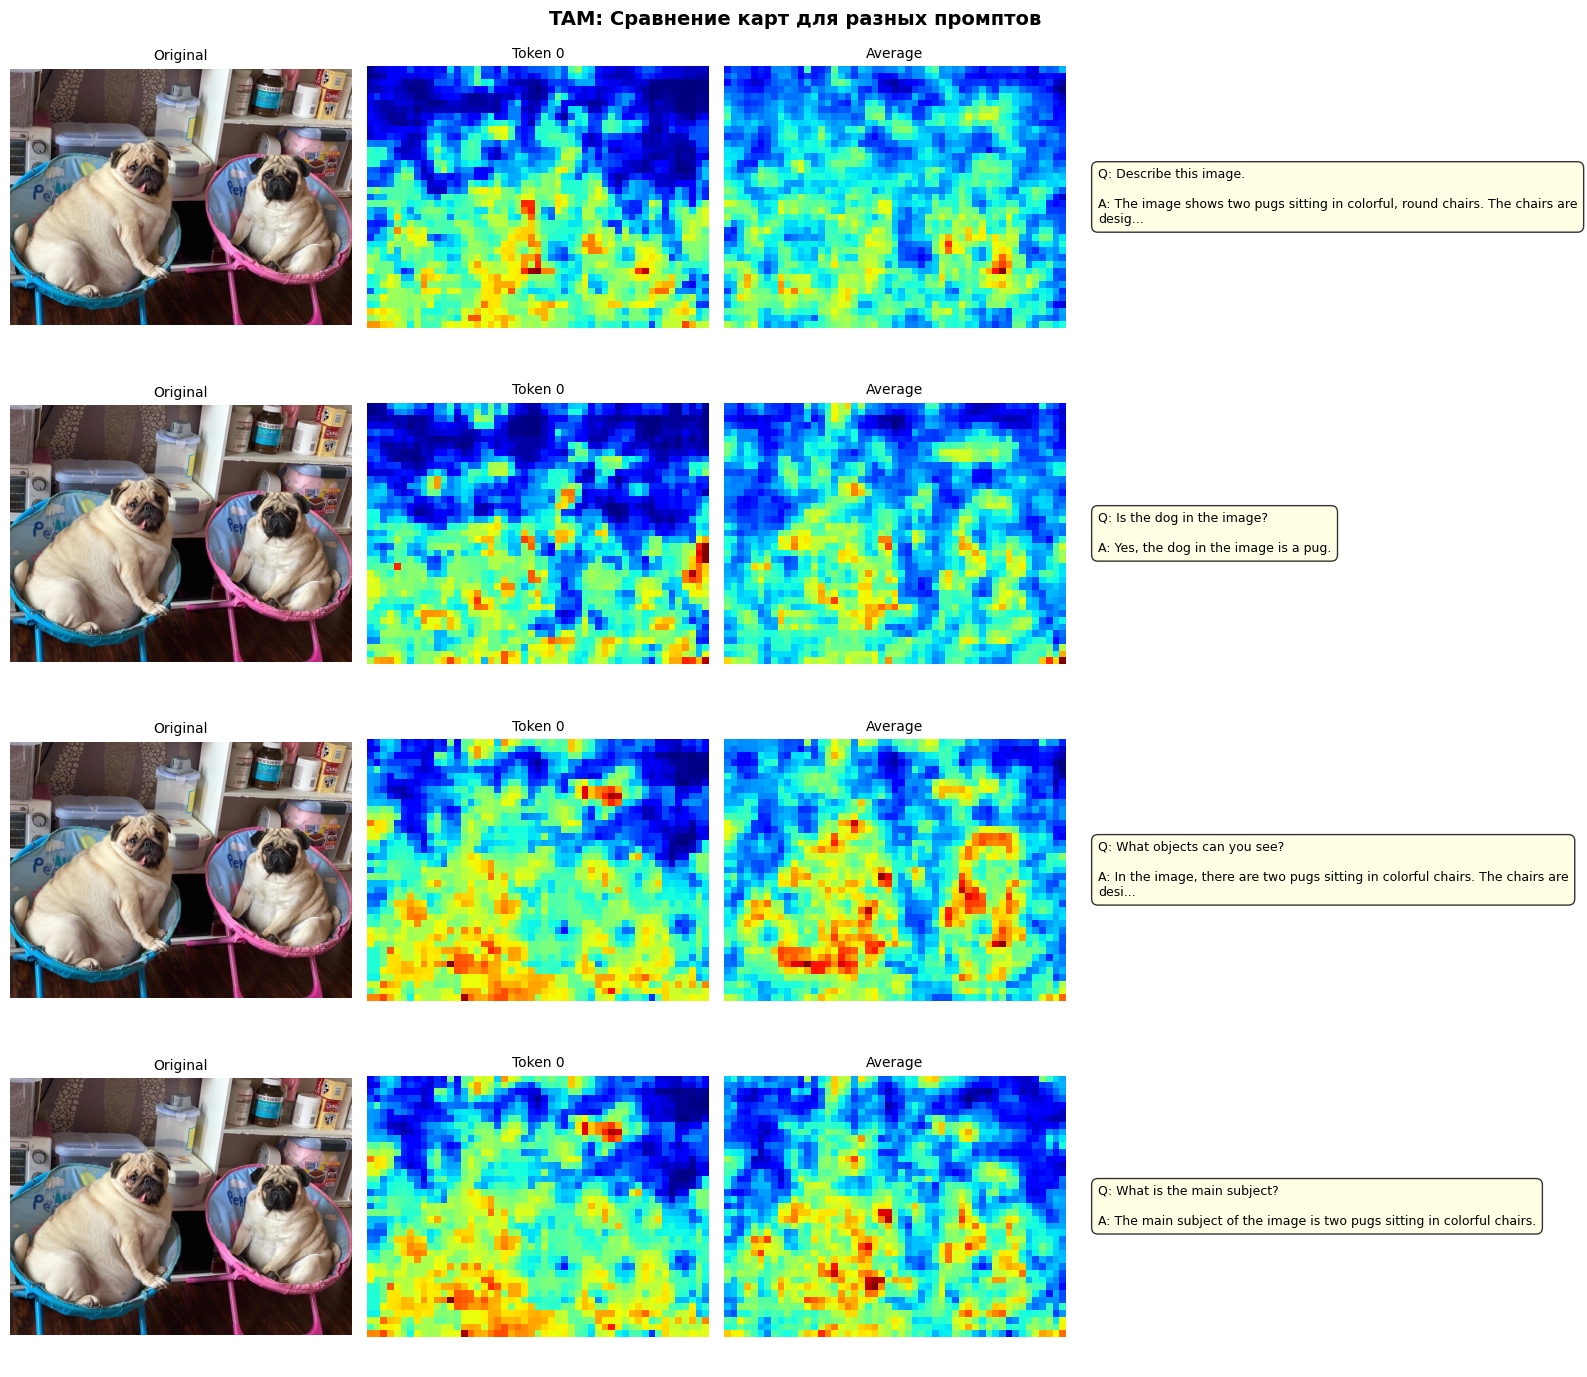

In [9]:
valid_results = [(p, r) for p, r in all_results.items() if r and len(r['maps']) > 0]

fig, axes = plt.subplots(len(valid_results), 4, figsize=(16, 3.5 * len(valid_results)))
if len(valid_results) == 1:
    axes = [axes]

for row, (prompt, result) in enumerate(valid_results):
    # Original
    axes[row][0].imshow(Image.open(demo_image_path))
    axes[row][0].set_title('Original', fontsize=10)
    axes[row][0].axis('off')
    
    # Token 0
    if len(result['maps']) > 0 and isinstance(result['maps'][0], np.ndarray):
        axes[row][1].imshow(result['maps'][0], cmap='jet')
        axes[row][1].set_title('Token 0', fontsize=10)
    axes[row][1].axis('off')
    
    # Average map
    valid_maps = [m for m in result['maps'] if isinstance(m, np.ndarray)]
    if valid_maps:
        avg_map = np.mean(valid_maps, axis=0)
        axes[row][2].imshow(avg_map, cmap='jet')
        axes[row][2].set_title('Average', fontsize=10)
    axes[row][2].axis('off')
    
    # Prompt + Response
    axes[row][3].axis('off')
    response_short = result['text'][:80] + ('...' if len(result['text']) > 80 else '')
    text_content = f"Q: {prompt}\n\nA: {response_short}"
    axes[row][3].text(0.05, 0.5, text_content, ha='left', va='center', fontsize=9,
                      wrap=True, transform=axes[row][3].transAxes,
                      bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

plt.suptitle('TAM: Сравнение карт для разных промптов', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Выводы
 - ТАМ справился действительно хорошо, особенно это видно на подробном примере с тепловой карте всего ответа модели
 - Интегрально тоже видно, что модель смотрит куда нужно
 - Но тут все еще есть куда расти
    - Взять больше модель
    - Посмотреть на больше картинок (где например разделение на объекты не такое очевидное)
